### Import Modules

In [ ]:
!pip install bertopic -q

In [23]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### 1. Import Reviews Dataset

In [5]:
review_chunks = pd.read_csv('review_chunks_with_sentiment_clean.csv')
review_chunks.head()

# review_chunks = review_chunks[:20]
# review_chunks_sample.head()

,review_id,chunk_id,hotel_name,review_score,sentiment,chunk_text,reviewer_name,reviewer_country,review_room_name,review_num_nights,review_stay_date,review_traveler_type
0,1,1_Positive_0,A Hotel Joo Chiat,10.0,Positive,Comfortable and convenient This was a last min...,Gabriela,United States,"Deluxe Twin, Window",2,Jan-25,Family
1,2,2_Positive_0,A Hotel Joo Chiat,7.0,Positive,Overall I'm quite happy with the stay except f...,A,Singapore,"Superior Double, No Window",4,Feb-25,Couple
2,2,2_Negative_0,A Hotel Joo Chiat,7.0,Negative,A little costly for a budget hotel.,A,Singapore,"Superior Double, No Window",4,Feb-25,Couple
3,3,3_Positive_0,A Hotel Joo Chiat,8.0,Positive,Good and achieve my expectation,Sumarni,Australia,"Superior Twin, No Window",3,Feb-25,Group
4,3,3_Negative_0,A Hotel Joo Chiat,8.0,Negative,The fire alarm and no communication with the p...,Sumarni,Australia,"Superior Twin, No Window",3,Feb-25,Group


In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from transformers import pipeline
import spacy

# Load spaCy
try:
    nlp = spacy.load("en_core_web_sm")
except:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Load sentiment classifier
sentiment_classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def topic_guided_sentiment(review_chunks, min_topic_size=10, verbose=True):
    """
    Topic-guided sentence-level sentiment classification (not true ABSA).
    
    Args:
        review_chunks (DataFrame): Must contain 'chunk_text', 'review_id', 'chunk_id', 'hotel_name'
        min_topic_size (int): Minimum size for topic extraction in BERTopic
        verbose (bool): Whether to print progress logs
        
    Returns:
        topic_sentiment_df (DataFrame): Sentence-level sentiment associated with dominant topic
    """
    if verbose:
        print("🔍 Loading sentence embedding model...")
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

    texts = review_chunks['chunk_text'].tolist()

    if verbose:
        print("🧠 Creating document embeddings...")
    embeddings = sentence_model.encode(texts, show_progress_bar=verbose)

    if verbose:
        print("🧵 Running BERTopic for topic discovery...")
    vectorizer = CountVectorizer(stop_words="english")
    topic_model = BERTopic(
        vectorizer_model=vectorizer,
        min_topic_size=min_topic_size,
        verbose=verbose
    )
    topics, _ = topic_model.fit_transform(texts, embeddings)

    topic_labels = {}
    for topic_id in topic_model.get_topic_info()['Topic'].tolist():
        if topic_id != -1:
            words = topic_model.get_topic(topic_id)
            topic_labels[topic_id] = words[0][0] if words else f"Topic_{topic_id}"

    if verbose:
        print(f"📌 Extracted {len(topic_labels)} topic labels.")
        print("🔎 Classifying sentiment at sentence level...")

    results = []

    for i, row in enumerate(tqdm(review_chunks.itertuples(index=False), total=len(review_chunks), disable=not verbose)):
        review_id = row.review_id
        chunk_id = row.chunk_id
        hotel_name = row.hotel_name
        text = row.chunk_text
        topic_id = topics[i]

        if topic_id == -1:
            continue

        topic_words = topic_model.get_topic(topic_id)
        topic_label = topic_labels.get(topic_id, f"Topic_{topic_id}")
        topic_keywords = [w for w, _ in topic_words[:5]] if topic_words else []

        doc = nlp(text)

        for sentence in doc.sents:
            sent_text = sentence.text
            sent_text_lower = sent_text.lower()

            if any(word in sent_text_lower for word in topic_keywords):
                try:
                    sentiment_output = sentiment_classifier(sent_text)[0]
                    sentiment = sentiment_output["label"].capitalize()
                    confidence = round(sentiment_output["score"], 4)
                except Exception as e:
                    if verbose:
                        print(f"⚠️ Sentiment analysis failed: {e}")
                    continue

                results.append({
                    "review_id": review_id,
                    "chunk_id": chunk_id,
                    "hotel_name": hotel_name,
                    "topic_label": topic_label,
                    "sentence_sentiment": sentiment,
                    "sentiment_confidence": confidence,
                    "topic_id": topic_id
                })

    topic_sentiment_df = pd.DataFrame(results)

    # Step 1: Aggregate average confidence per sentiment
    avg_conf_df = (
        topic_sentiment_df
        .groupby(["review_id", "chunk_id", "topic_label", "sentence_sentiment"])
        .agg(avg_confidence=("sentiment_confidence", "mean"))
        .reset_index()
    )

    # Step 2: Select sentiment with highest average confidence
    resolved_df = (
        avg_conf_df.sort_values("avg_confidence", ascending=False)
                   .drop_duplicates(subset=["review_id", "chunk_id", "topic_label"], keep="first")
    )

    # Step 3: Merge metadata back in (hotel_name, topic_id)
    resolved_df = (
        resolved_df.merge(
            topic_sentiment_df[["review_id", "chunk_id", "topic_label", "hotel_name", "topic_id"]],
            on=["review_id", "chunk_id", "topic_label"],
            how="left"
        ).drop_duplicates(["review_id", "chunk_id", "topic_label"])
        .rename(columns={
            "sentence_sentiment": "final_sentiment",
            "avg_confidence": "final_confidence"
        })
        .reset_index(drop=True)
    )

    return resolved_df

# Run updated pipeline
topic_sentiment_df = topic_guided_sentiment(review_chunks, min_topic_size=20, verbose=True)
topic_sentiment_df



Device set to use cpu


🔍 Loading sentence embedding model...
🧠 Creating document embeddings...


Batches:   0%|          | 0/9166 [00:00<?, ?it/s]

🧵 Running BERTopic for topic discovery...


2025-04-18 12:38:52,324 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-18 12:46:51,187 - BERTopic - Dimensionality - Completed ✓
2025-04-18 12:46:51,232 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-18 12:47:51,631 - BERTopic - Cluster - Completed ✓
2025-04-18 12:47:51,803 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-18 12:48:08,363 - BERTopic - Representation - Completed ✓


📌 Extracted 820 topic labels.
🔎 Classifying sentiment at sentence level...


100%|██████████| 293302/293302 [3:07:02<00:00, 26.13it/s]   


,review_id,chunk_id,topic_label,final_sentiment,final_confidence,hotel_name,topic_id
0,38145,38145_Positive_0,clean,Positive,0.9999,The Quay Hotel,38
1,133627,133627_Positive_0,breakfast,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,55
2,133647,133647_Positive_0,singapore,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,7
3,133649,133649_Positive_0,rooftop,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,276
4,133653,133653_Positive_0,friendly,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,11
...,...,...,...,...,...,...,...
142254,122759,122759_Negative_0,variety,Positive,0.5007,The Robertson House by The Crest Collection,17
142255,123610,123610_Negative_0,variety,Positive,0.5007,The Robertson House by The Crest Collection,17
142256,40257,40257_Positive_0,singapore,Positive,0.5003,One Farrer Hotel,7
142257,131246,131246_Positive_0,crowne,Positive,0.5001,Crowne Plaza Changi Airport by IHG,695


In [7]:
topic_sentiment_df.to_csv('topic_sentiment_df.csv', index=False)
print("Saved topic sentiment DataFrame to 'topic_sentiment_df.csv'")

Saved topic sentiment DataFrame to 'topic_sentiment_df.csv'


### 2. Preprocess Topic Labels

In [4]:
topic_sentiment_df = pd.read_csv('topic_sentiment_df.csv')
topic_sentiment_df

,review_id,chunk_id,topic_label,final_sentiment,final_confidence,hotel_name,topic_id
0,38145,38145_Positive_0,clean,Positive,0.9999,The Quay Hotel,38
1,133627,133627_Positive_0,breakfast,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,55
2,133647,133647_Positive_0,singapore,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,7
3,133649,133649_Positive_0,rooftop,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,276
4,133653,133653_Positive_0,friendly,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,11
...,...,...,...,...,...,...,...
142254,122759,122759_Negative_0,variety,Positive,0.5007,The Robertson House by The Crest Collection,17
142255,123610,123610_Negative_0,variety,Positive,0.5007,The Robertson House by The Crest Collection,17
142256,40257,40257_Positive_0,singapore,Positive,0.5003,One Farrer Hotel,7
142257,131246,131246_Positive_0,crowne,Positive,0.5001,Crowne Plaza Changi Airport by IHG,695


In [6]:
# Total count of mentions per topic (across all sentiments)
topic_counts = (
    topic_sentiment_df
    .groupby("topic_label")
    .size()
    .sort_values(ascending=False)
)

print(f"Unique topics: {len(topic_counts)} \n")

# Top 10 most mentioned topics
print("🔥 Top topic labels by count:")
print(topic_counts.head(50))

# Bottom 10 least mentioned topics
print("\n❄️ Bottom topic labels by count:")
print(topic_counts.tail(50))


Unique topics: 537 

🔥 Top topic labels by count:
topic_label
mrt           5795
breakfast     5057
pool          4872
airport       4845
spacious      4093
singapore     3964
ac            2598
check         2387
friendly      1914
chinatown     1913
bookingcom    1873
value         1758
window        1661
hostel        1652
orchard       1613
quay          1609
buffet        1518
definitely    1514
variety       1495
bed           1411
tv            1335
clean         1303
marina        1296
smell         1294
pod           1291
et            1260
changi        1246
wifi          1218
price         1108
capsule       1096
luggage       1051
noise         1001
sentosa        983
cleaning       913
bottles        897
bugis          892
star           866
india          864
twin           850
accessible     823
staff          805
comfy          801
lounge         799
milk           799
bidet          792
helpful        783
reception      782
desk           774
und            771
noisy  

In [7]:
taxonomy = {
    "room": {
        "room_size": ["spacious", "compact", "smaller", "small", "tiny", "cramp"],
        "bed_comfort": ["bed", "beds", "mattress", "pillow", "pillows", "blanket", "sheets"],
        "climate_control": ["aircon", "fan", "ventilation", "humid"],
        "room_cleanliness": ["clean", "cleaning", "dirty", "dusty", "tidy"],
        "furniture": ["desk", "chair", "sofa", "lighting", "mirror", "curtains", "locker", "wardrobe"],
        "noise_level": ["noise", "noisy", "quiet", "insulation", "soundproof", "walls"],
        "room_design": ["modern", "dated", "ambience", "ambiente", "style"],
        "privacy": ["partition", "shared", "private"],
        "view": ["window", "windows", "balcony", "view"]
    },
    "bathroom": {
        "bathroom_cleanliness": ["mold", "mould", "smell", "odor", "wet", "soap", "dirty", "dusty"],
        "fixtures": ["shower", "bathtub", "bidet", "sink", "toilet", "toilets", "washroom", "towels", "mirror"],
        "bathroom_design": ["bathroom", "bathrooms"],
        "ventilation": ["ventilation", "exhaust", "fan", "window"]
    },
    "location": {
        "proximity": ["orchard", "bugis", "chinatown", "sentosa", "marina", "katong", "lavender", "station", "airport", "changi", "jewel"],
        "convenience": ["mrt", "metro", "accessible", "location", "nearby", "central", "walkable"],
        "neighborhood": ["geylang", "raffles", "mustafa", "shopping", "district"],
        "noise": ["traffic", "quiet", "noisy"]
    },
    "service": {
        "staff_attitude": ["friendly", "helpful", "rude", "polite", "welcoming", "smile"],
        "checkin_checkout": ["check", "checkin", "checkout", "booking", "bookingcom", "reception", "receptionist", "concierge"],
        "housekeeping": ["cleaning", "housekeeping", "laundry", "towels", "makeup", "refresh"],
        "issue_resolution": ["complain", "complaints", "support", "maintenance"]
    },
    "food": {
        "breakfast_quality": ["breakfast", "buffet", "variety", "spread"],
        "dietary_options": ["vegetarian", "halal", "gluten"],
        "food_availability": ["food", "restaurant", "dining", "meal", "snacks", "coffee", "fruit"],
        "taste": ["delicious", "tasty", "cold", "bland"]
    },
    "amenities": {
        "tech": ["wifi", "tv", "usb", "power", "laptop"],
        "in_room": ["fridge", "kettle", "microwave", "minibar", "iron", "phone"],
        "leisure": ["gym", "pool", "spa", "bar", "sauna", "billiard", "lounge"],
        "accessibility": ["accessible", "wheelchair", "elderly", "lift", "elevator", "stairs"]
    },
    "value": {
        "price": ["price", "expensive", "cheap", "value", "budget", "affordable", "deal"],
        "worth_it": ["included", "free", "worth", "overpriced"]
    },
    "logistics": {
        "transport": ["bus", "taxi", "shuttle", "train", "tram", "monorail"],
        "parking": ["parking", "garage", "valet"],
        "storage": ["luggage", "locker", "suitcases", "bags", "storage"],
        "directions": ["map", "signage", "entrance"]
    }
}


# Clear topic category mapping (main_topic_category, sub_topic_category)
topic_category_mapping = {}
for main_category, subcategories in taxonomy.items():
    for subcategory, topic_keywords in subcategories.items():
        for keyword in topic_keywords:
            topic_category_mapping[keyword] = {
                "main_topic_category": main_category,
                "sub_topic_category": subcategory
            }

# Apply this mapping to the topic labels in df
mapped_topic_categories = topic_sentiment_df["topic_label"].apply(
    lambda label: topic_category_mapping.get(label, {"main_topic_category": "other", "sub_topic_category": "other"})
)

# Expand into columns and merge
mapped_topic_df = pd.DataFrame(mapped_topic_categories.tolist())
topic_counts_categorized = pd.concat([topic_sentiment_df, mapped_topic_df], axis=1)
topic_counts_categorized


,review_id,chunk_id,topic_label,final_sentiment,final_confidence,hotel_name,topic_id,main_topic_category,sub_topic_category
0,38145,38145_Positive_0,clean,Positive,0.9999,The Quay Hotel,38,room,room_cleanliness
1,133627,133627_Positive_0,breakfast,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,55,food,breakfast_quality
2,133647,133647_Positive_0,singapore,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,7,other,other
3,133649,133649_Positive_0,rooftop,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,276,other,other
4,133653,133653_Positive_0,friendly,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,11,service,staff_attitude
...,...,...,...,...,...,...,...,...,...
142254,122759,122759_Negative_0,variety,Positive,0.5007,The Robertson House by The Crest Collection,17,food,breakfast_quality
142255,123610,123610_Negative_0,variety,Positive,0.5007,The Robertson House by The Crest Collection,17,food,breakfast_quality
142256,40257,40257_Positive_0,singapore,Positive,0.5003,One Farrer Hotel,7,other,other
142257,131246,131246_Positive_0,crowne,Positive,0.5001,Crowne Plaza Changi Airport by IHG,695,other,other


In [8]:
# count number of valid rows
topic_counts_categorized[topic_counts_categorized['main_topic_category'] != 'other'].shape[0] 

83148

In [9]:
# Filter out rows labeled as "other"
filtered_topic_counts_categorized = topic_counts_categorized[topic_counts_categorized['main_topic_category'] != 'other']
filtered_topic_counts_categorized


,review_id,chunk_id,topic_label,final_sentiment,final_confidence,hotel_name,topic_id,main_topic_category,sub_topic_category
0,38145,38145_Positive_0,clean,Positive,0.9999,The Quay Hotel,38,room,room_cleanliness
1,133627,133627_Positive_0,breakfast,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,55,food,breakfast_quality
4,133653,133653_Positive_0,friendly,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,11,service,staff_attitude
6,35793,35793_Positive_0,airport,Positive,0.9999,Hotel 81 Changi,0,location,proximity
7,133684,133684_Positive_0,spacious,Positive,0.9999,Holiday Inn Express Singapore Clarke Quay by IHG,1,room,room_size
...,...,...,...,...,...,...,...,...,...
142248,94967,94967_Negative_0,breakfast,Positive,0.5019,Hotel NuVe,77,food,breakfast_quality
142249,146643,146643_Negative_0,pool,Negative,0.5018,Paradox Singapore Merchant Court at Clarke Quay,4,amenities,leisure
142252,34766,34766_Positive_0,changi,Positive,0.5010,Hotel Classic by Venue,18,location,proximity
142254,122759,122759_Negative_0,variety,Positive,0.5007,The Robertson House by The Crest Collection,17,food,breakfast_quality


In [10]:
agg_df = filtered_topic_counts_categorized.groupby(["hotel_name", "main_topic_category", "sub_topic_category", "final_sentiment"]).agg(
    count=("final_sentiment", "size"),
).reset_index()

agg_df

,hotel_name,main_topic_category,sub_topic_category,final_sentiment,count
0,30 Bencoolen,amenities,accessibility,Negative,1
1,30 Bencoolen,amenities,accessibility,Positive,3
2,30 Bencoolen,amenities,in_room,Negative,7
3,30 Bencoolen,amenities,leisure,Negative,35
4,30 Bencoolen,amenities,leisure,Positive,46
...,...,...,...,...,...
12237,voco Orchard Singapore by IHG,service,housekeeping,Negative,4
12238,voco Orchard Singapore by IHG,service,staff_attitude,Positive,11
12239,voco Orchard Singapore by IHG,value,price,Negative,1
12240,voco Orchard Singapore by IHG,value,price,Positive,2


In [11]:
# Step 1: Pivot counts of Positive and Negative per hotel/topic
pivot_df = agg_df.pivot_table(
    index=["hotel_name", "main_topic_category", "sub_topic_category"],
    columns="final_sentiment",
    values="count",
    aggfunc="sum",
    fill_value=0
).reset_index()

# Step 2: Rename columns for clarity
pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={
    "Positive": "positive_count",
    "Negative": "negative_count"
})

# Step 3: Compute satisfaction_score
pivot_df["total_count"] = pivot_df["positive_count"] + pivot_df["negative_count"]
pivot_df["positive_sentiment_ratio"] = pivot_df["positive_count"] / pivot_df["total_count"]

# Step 4: Compute bayesian score for fairer comparison
aspect_avg_sentiment = (
    pivot_df.groupby("sub_topic_category")
    .apply(lambda df: df["positive_count"].sum() / df["total_count"].sum())
)

pivot_df["aspect_prior"] = pivot_df["sub_topic_category"].map(aspect_avg_sentiment) 

m = 30 # Prior count for Bayesian smoothing
pivot_df["bayesian_score"] = (pivot_df["positive_count"] + m * pivot_df['aspect_prior']) / (pivot_df["total_count"] + m)

pivot_df


,hotel_name,main_topic_category,sub_topic_category,negative_count,positive_count,total_count,positive_sentiment_ratio,aspect_prior,bayesian_score
0,30 Bencoolen,amenities,accessibility,1,3,4,0.750000,0.475165,0.507498
1,30 Bencoolen,amenities,in_room,7,0,7,0.000000,0.160714,0.130309
2,30 Bencoolen,amenities,leisure,35,46,81,0.567901,0.726578,0.610787
3,30 Bencoolen,amenities,tech,6,3,9,0.333333,0.109832,0.161409
4,30 Bencoolen,bathroom,bathroom_cleanliness,9,1,10,0.100000,0.080537,0.085403
...,...,...,...,...,...,...,...,...,...
8357,voco Orchard Singapore by IHG,service,checkin_checkout,10,3,13,0.230769,0.233509,0.232681
8358,voco Orchard Singapore by IHG,service,housekeeping,4,0,4,0.000000,0.137518,0.121339
8359,voco Orchard Singapore by IHG,service,staff_attitude,0,11,11,1.000000,0.838185,0.881599
8360,voco Orchard Singapore by IHG,value,price,1,2,3,0.666667,0.590368,0.597304


In [18]:
pivot_df = pivot_df.drop(columns=["aspect_prior"])

pivot_df.to_csv('topic_sentiment_hotel_summary.csv', index=False)
print("Saved topic sentiment hotel summary to 'topic_sentiment_hotel_summary.csv'")

Saved topic sentiment hotel summary to 'topic_sentiment_hotel_summary.csv'


### 3. Visualisation

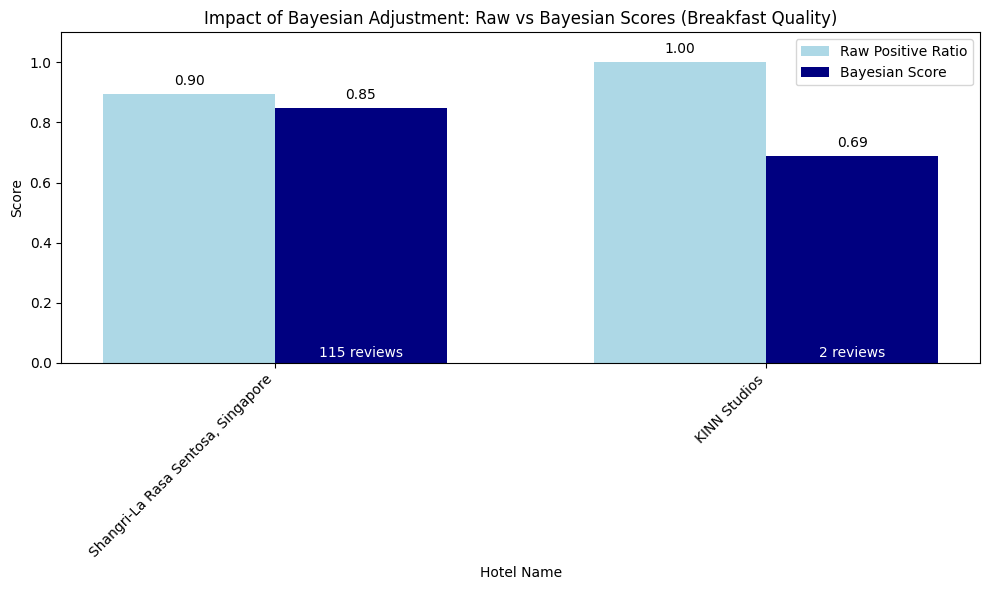

In [40]:
# Step 1: Filter for the aspect you want to focus on (e.g., 'breakfast_quality')
compare_df = pivot_df[pivot_df['sub_topic_category'] == 'breakfast_quality'].copy()

# Step 2: Select interesting contrasts manually

# # (1) Small hotel: few reviews, large Bayesian adjustment
# small_hotel = compare_df[compare_df['total_count'] < 50].sort_values(
#     by='bayesian_score', ascending=False).head(1)

# (2) Large hotel: many reviews, minimal adjustment
large_hotel = compare_df[compare_df['total_count'] > 100].sort_values(
    by='bayesian_score', ascending=False).head(1)

# (3) High raw score but lower Bayesian score
high_raw_lower_bayesian = compare_df.sort_values(
    by='positive_sentiment_ratio', ascending=False).head(10)
high_raw_lower_bayesian = high_raw_lower_bayesian[
    high_raw_lower_bayesian['bayesian_score'] < high_raw_lower_bayesian['positive_sentiment_ratio']
].head(1)

# # (4) Low raw score but better Bayesian score
# low_raw_higher_bayesian = compare_df.sort_values(
#     by='positive_sentiment_ratio', ascending=True).head(10)
# low_raw_higher_bayesian = low_raw_higher_bayesian[
#     low_raw_higher_bayesian['bayesian_score'] > low_raw_higher_bayesian['positive_sentiment_ratio']
# ].head(1)

# Step 3: Combine selections
selected_hotels = pd.concat([large_hotel, high_raw_lower_bayesian])

# Step 4: Plot
import numpy as np
x = np.arange(len(selected_hotels['hotel_name']))
width = 0.35

# Add bar labels and include review count as annotation
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, selected_hotels['positive_sentiment_ratio'], width, label='Raw Positive Ratio', color='lightblue')
bars2 = ax.bar(x + width/2, selected_hotels['bayesian_score'], width, label='Bayesian Score', color='navy')

# Add text labels above each bar
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    count = selected_hotels.iloc[i]['total_count']
    ax.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.02,
            f"{bar1.get_height():.2f}", ha='center', va='bottom', fontsize=10)
    ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.02,
            f"{bar2.get_height():.2f}", ha='center', va='bottom', fontsize=10)
    ax.text(bar2.get_x() + bar2.get_width()/2, 0.01,
            f"{int(count)} reviews", ha='center', va='bottom', fontsize=10, color='white')

# Format axes
ax.set_xlabel('Hotel Name')
ax.set_ylabel('Score')
ax.set_title('Impact of Bayesian Adjustment: Raw vs Bayesian Scores (Breakfast Quality)')
ax.set_xticks(x)
ax.set_xticklabels(selected_hotels['hotel_name'], rotation=45, ha="right")
ax.set_ylim(0, 1.1)
ax.legend()

plt.tight_layout()
plt.show()



In [32]:
pivot_df

,hotel_name,main_topic_category,sub_topic_category,negative_count,positive_count,total_count,positive_sentiment_ratio,aspect_prior,bayesian_score
0,30 Bencoolen,amenities,accessibility,1,3,4,0.750000,0.475165,0.507498
1,30 Bencoolen,amenities,in_room,7,0,7,0.000000,0.160714,0.130309
2,30 Bencoolen,amenities,leisure,35,46,81,0.567901,0.726578,0.610787
3,30 Bencoolen,amenities,tech,6,3,9,0.333333,0.109832,0.161409
4,30 Bencoolen,bathroom,bathroom_cleanliness,9,1,10,0.100000,0.080537,0.085403
...,...,...,...,...,...,...,...,...,...
8357,voco Orchard Singapore by IHG,service,checkin_checkout,10,3,13,0.230769,0.233509,0.232681
8358,voco Orchard Singapore by IHG,service,housekeeping,4,0,4,0.000000,0.137518,0.121339
8359,voco Orchard Singapore by IHG,service,staff_attitude,0,11,11,1.000000,0.838185,0.881599
8360,voco Orchard Singapore by IHG,value,price,1,2,3,0.666667,0.590368,0.597304


C:\Users\ong_z\AppData\Local\Temp\ipykernel_15340\1615262375.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_df['positive_sentiment_ratio'], shade=True, label='Raw Positive Ratio', color='skyblue')
C:\Users\ong_z\AppData\Local\Temp\ipykernel_15340\1615262375.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(filtered_df['bayesian_score'], shade=True, label='Bayesian Score', color='navy')


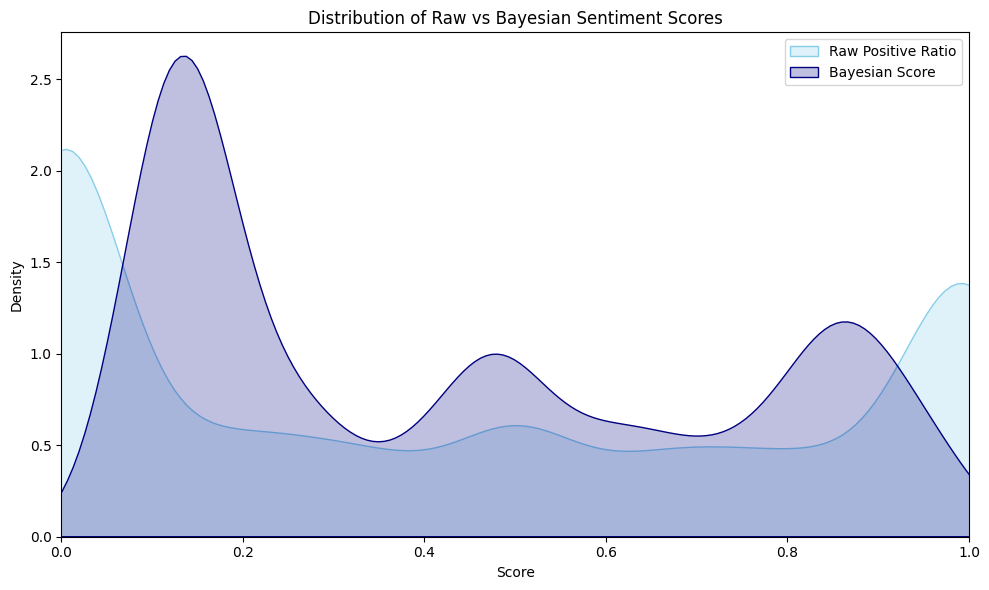

In [39]:
# Filter to include only hotels with a reasonable number of total reviews to avoid extreme noise
filtered_df = pivot_df[
    (pivot_df['total_count'] >= 5) 
    # & (pivot_df['main_topic_category'] == 'amenities')
]

filtered_df = pivot_df.copy()
plt.figure(figsize=(10, 6))

# Plot overlapping KDE plots (distribution curves)
sns.kdeplot(filtered_df['positive_sentiment_ratio'], shade=True, label='Raw Positive Ratio', color='skyblue')
sns.kdeplot(filtered_df['bayesian_score'], shade=True, label='Bayesian Score', color='navy')

plt.title('Distribution of Raw vs Bayesian Sentiment Scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.xlim(0, 1)
plt.tight_layout()
plt.show()
